In [5]:
import os

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,Add
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import numpy as np

import sys
sys.path.append("./")
from tf__resnet.resnet_builder.resnet import ResnetBuilder

## dataset 

#### load and standardizing dataset

In [2]:
# CIFAR 10 Information
class_num = 10
ch_num = 3

# The data, shuffled and split between train and test sets:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
# Convert class vectors to binary class matrices.
Y_train = to_categorical(y_train, class_num)
Y_test = to_categorical(y_test, class_num)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# subtract mean and normalize
mean_image = np.mean(X_train)
X_train -= mean_image
X_test -= mean_image
X_train /= 128.
X_test /= 128.

#### create a train dataset for eval whose data size is same as test data.

In [3]:
def data_balance(labels,data_num):
    """data choice function for label balanced data
    """
    labels_dic = {}
    ids = np.arange(labels.shape[0])
    for label in range(len(np.unique(labels))):
        label_choice = ids[labels==label]
        shfl = np.random.choice(label_choice.shape[0], data_num, replace=False)
        labels_dic[label] = label_choice[shfl]
    data_choice = np.concatenate([labels_dic[label] for label in labels_dic.keys()],axis=0)
    shfl = np.random.choice(data_choice.shape[0],data_choice.shape[0],replace=False)
    data_choice = data_choice[shfl]

    # check
    shfl_labels = labels[data_choice]
    assert len(np.unique(shfl_labels)) == len(np.unique(labels))
    assert (np.unique(shfl_labels,return_counts=True)[1] == data_num).all()

    return data_choice

In [4]:
choice = data_balance(y_train.reshape(-1),data_num=Y_test.shape[0]//10)
X_train_eval = X_train[choice]
Y_train_eval = Y_train[choice]
np.sum(Y_train_eval,axis=0)

array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
       1000.], dtype=float32)

In [5]:
# random flip image
def flip_image(image):
    return tf.image.random_flip_left_right(image)

# random crop shift range
shift_range = 0.1
expand_target_size = int(img_size*(shift_range+1))
def image_shift(image):
    # padding
    image = tf.image.resize_with_crop_or_pad(
                    image,
                    expand_target_size,
                    expand_target_size
                    )
    #random crop
    image = tf.image.random_crop(
                    image,
                    size=[img_size, img_size, ch_num]
                    )
    return image

# usual minibatch training

In [6]:
class training_model():
    def __init__(self,X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=32):
        self.model = ResnetBuilder(name="ResNet18", mode="2D",include_top=True, class_num=10)
        self.model(Input((32,32,3)))
        self.model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
        self.model.summary()
        self.model_vals = self.model.trainable_variables
        self.batch_size = batch_size
        self.create_dataset(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test)


 
    def create_dataset(self, X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test):
        # create train dataset 
        input_ds = tf.data.Dataset.from_tensor_slices(X_train)
        input_ds = input_ds.map(flip_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).map(image_shift,num_parallel_calls=tf.data.experimental.AUTOTUNE)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train)
        train_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_iter = iter(train_ds)
        self.train_batch_num = int(np.ceil(X_train.shape[0]/self.batch_size))

        # crate train dataset for eval
        input_ds = tf.data.Dataset.from_tensor_slices(X_train_eval)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_train_eval)
        self.train_e_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()
        self.train_e_batch_num = int(np.ceil(X_train_eval.shape[0]/self.batch_size))

        # create test
        input_ds = tf.data.Dataset.from_tensor_slices(X_test)
        target_ds = tf.data.Dataset.from_tensor_slices(Y_test)
        self.test_ds = tf.data.Dataset.zip((input_ds, target_ds)).batch(self.batch_size).repeat()    
        self.test_batch_num =  int(np.ceil(X_test.shape[0]/self.batch_size))
    
    
    @tf.function
    def train_step(self,b_input, b_target):
        with tf.GradientTape() as tape:
            preds = self.model(b_input)
            loss = categorical_crossentropy(b_target, preds)
        grads = tape.gradient(loss, self.model_vals)
        self.optimizer.apply_gradients(zip(grads, self.model_vals))

        
    def minibatch_training(self):
            b_input, b_target = next(self.train_iter)
            self.train_step(b_input,b_target)
                
                       
    def train(self,
                    epochs=200, 
                    max_patience=5, # early stop patience
                    ):
        
        self.optimizer =  tf.keras.optimizers.Adam() # optimizer setting
        losses = [] # valid loss history
        patience=0 # early stop patience
        
        #First Evaluation
        print("First_evaluation")
        [train_loss, train_acc] = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=1)
        [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=1)
        best_train_losses = [train_loss, train_acc]
        best_valid_losses = [valid_loss, valid_acc]
        min_loss = valid_loss
        #losses.append(valid_loss)
        print("epoch:",0,"-----",end="")
        print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
        print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4))
        print("batch num ",self.train_batch_num)
        # start training
        for epoch in range(epochs):
            for batch in range(self.train_batch_num):
                # minibatch training
                self.minibatch_training()
                
            # evaluation at epoch end
            [train_loss, train_acc] = self.model.evaluate(self.train_e_ds,steps=self.train_e_batch_num, verbose=0)
            [valid_loss, valid_acc] = self.model.evaluate(self.test_ds,steps=self.test_batch_num, verbose=0)
            losses.append(valid_loss)
            print("epoch:",epoch+1,"-----",end="")
            print("train loss :",round(train_loss, 4), ",train acc: ",round(train_acc, 4),end="")
            print(",  valid loss :",round(valid_loss, 4), ",vaild acc: ",round(valid_acc, 4),end="")
            
            if min_loss > valid_loss:
                self.model.save_weights(os.path.join("./model.h5", ))
                best_train_losses = [train_loss, train_acc]
                best_valid_losses = [valid_loss, valid_acc]
                min_loss = valid_loss
                patience=0
                print("     loss improved!")
            else:
                patience+=1
                print("")
                
            # early stopping
            if patience>max_patience:break

        print("-------------------------------")
        print("Training Results at best validation loss")
        print("train loss :",round(best_train_losses[0], 4), ",train acc: ",round(best_train_losses[1], 4),end="")
        print(",  valid loss :",round(best_valid_losses[0], 4), ",vaild acc: ",round(best_valid_losses[1], 4))
        
        return losses, [best_train_losses,best_valid_losses]

In [21]:
# minbatch 128
test128 = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=128)
test128_results = test128.train()
test128_losses = test128_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_8 (Conv_st (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_32 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_32 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_33 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_33 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_34 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_34 (Ide (None, 2, 2, 256)         118

In [10]:
# minbatch 64
test64 = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=64)
test64_results = test64.train()
test64_losses = test64_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_3 (Conv_st (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_12 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_12 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_13 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_13 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_14 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_14 (Ide (None, 2, 2, 256)         118

In [7]:
# minbatch 32
test32 = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=32)
test32_results = test32.train()
test32_losses = test32_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block (Conv_stag (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block (Conv_basic (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block (Identi (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_1 (Conv_bas (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_1 (Iden (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_2 (Conv_bas (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_2 (Iden (None, 2, 2, 256)         118

In [28]:
# minbatch 1
test1 = training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=1)
test1_results = test1.train()
test1_losses = test1_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_15 (Conv_s (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_60 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_60 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_61 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_61 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_62 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_62 (Ide (None, 2, 2, 256)         118

# minibatch accumulation

In [14]:
class accum_training_model(training_model):
    def __init__(self,X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size,batch_accumulate_num):
        '''
        add instance variable, batch_accumulate_num which indicate minibatch accumulation.
        gradient is gotton from batch_accumulate_num*batch_size minbatch size 
        CASE 1:
            batch_accumulate_num=128
            batch_size = 2
            effective batch size = 256
        '''
        super().__init__(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size)
        self.batch_accumulate_num = batch_accumulate_num
        self.train_batch_num = int(np.ceil(X_train.shape[0]/self.batch_size/self.batch_accumulate_num))
    
    def gradient_sum(self,GRADS):
        '''sum of gradient which is accumulated by each mini batch calculation '''
        grads_sum = []
        for l_i in range(len(GRADS[0])):
            tmp = []
            for a_i in range(len(GRADS)):
                tmp.append(GRADS[a_i][l_i])
            grads_sum.append(tf.math.add_n(tmp))
        return grads_sum


    def gradient_mean(self,SUM_GRADS):
        '''calucate mean gradient from sum gradient'''
        assert len(SUM_GRADS)==1
        mean_grads = []
        for l_i in range(len(SUM_GRADS[0])):
            mean_grads.append(SUM_GRADS[0][l_i] / self.batch_accumulate_num)
        return mean_grads


    @tf.function
    def train_step(self,b_input, b_target):
        with tf.GradientTape() as tape:
            preds = self.model(b_input)
            loss = categorical_crossentropy(b_target, preds)
        grads = tape.gradient(loss, self.model_vals)
        return grads


    def accumulate_train_step(self,grad_mode="avg"):
        '''optimization with batch gradient accumulation
        '''
        # gradient accumulation
        GRADS = []
        for acc_i in range(self.batch_accumulate_num):
            b_input, b_target = next(self.train_iter)
            grads = self.train_step(b_input, b_target)
            if acc_i ==0:
                GRADS = [grads]
            else:
                GRADS.append(grads)
                GRADS = [self.gradient_sum(GRADS)]

        # update with mean gradients
        if grad_mode=="avg":
            GRADS = self.gradient_mean(GRADS)
        elif grad_mode=="sum":
            GRADS = GRADS[0]
        else:
            raise Exception("grad_mode Error")

        self.optimizer.apply_gradients(zip(GRADS, self.model_vals))

        
        
    def minibatch_training(self):
            b_input, b_target = next(self.train_iter)
            self.accumulate_train_step()

In [23]:
test_acc128 = accum_training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=1,batch_accumulate_num=128)
test_acc128_results = test_acc128.train()
test_acc128_losses = test_acc128_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_10 (Conv_s (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_40 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_40 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_41 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_41 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_42 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_42 (Ide (None, 2, 2, 256)         118

In [ ]:
test_acc64 = accum_training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=1,batch_accumulate_num=64)
test_acc64_results = test_acc64.train()
test_acc64_losses = test_acc64_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_16 (Conv_s (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_64 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_64 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_65 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_65 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_66 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_66 (Ide (None, 2, 2, 256)         118

In [ ]:
test_acc32 = accum_training_model(X_train,Y_train, X_train_eval, Y_train_eval, X_test,Y_test, batch_size=1,batch_accumulate_num=32)
test_acc32_results = test_acc32.train()
test_acc32_losses = test_acc32_results[0]

Model: "ResNet18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_stage1_block_17 (Conv_s (None, 8, 8, 64)          9728      
_________________________________________________________________
conv_basic_block_68 (Conv_ba (None, 8, 8, 64)          46016     
_________________________________________________________________
identity_basic_block_68 (Ide (None, 8, 8, 64)          74368     
_________________________________________________________________
conv_basic_block_69 (Conv_ba (None, 4, 4, 128)         165248    
_________________________________________________________________
identity_basic_block_69 (Ide (None, 4, 4, 128)         296192    
_________________________________________________________________
conv_basic_block_70 (Conv_ba (None, 2, 2, 256)         658176    
_________________________________________________________________
identity_basic_block_70 (Ide (None, 2, 2, 256)         118

# visualization

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Read training results
df = pd.read_csv("CIFAR10_results.csv") 
df.head()

,experiment,epochs,trian loss,train acc,valid loss,valid acc
0,128,1,1.3660,0.5181,1.3690,0.5145
1,128,2,1.1795,0.5840,1.2139,0.5737
2,128,3,1.0405,0.6351,1.0950,0.6181
3,128,4,0.9414,0.6631,1.0068,0.6522
4,128,5,0.8955,0.6848,0.9802,0.6608


In [6]:
# experiment list 
exp_list = list(np.unique(df["experiment"]))
exp_list

['1', '128', '32', '64', 'acc 128', 'acc 256', 'acc 32', 'acc 64']

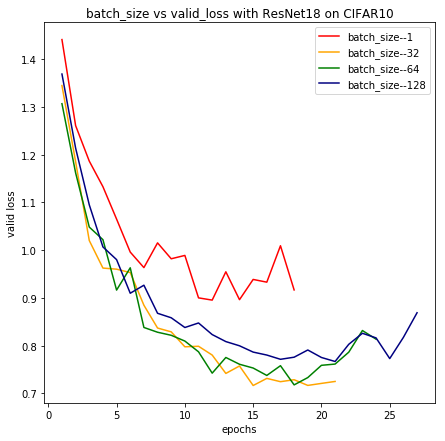

In [12]:
fig = plt.figure(figsize=(7,7))
plt.title("batch_size vs valid_loss with ResNet18 on CIFAR10")
plt.xlabel('epochs')
plt.ylabel('valid loss')
for batch,color in zip([1,32,64,128],
                                                            ["red","orange","green","navy","violet"]
                                                             ):

    losses = df[df["experiment"]==str(batch)]["valid loss"]
    epochs = df[df["experiment"]==str(batch)]["epochs"]
    plt.plot(epochs,losses,label="batch_size--"+str(batch),color=color)
    plt.legend()

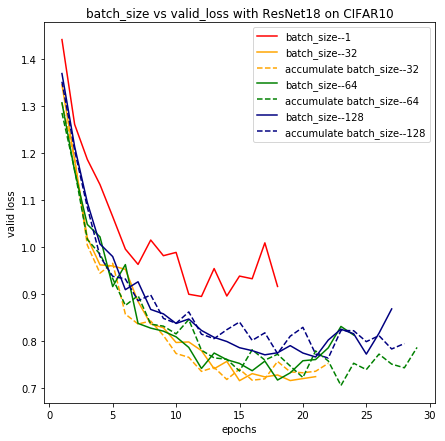

In [13]:
fig = plt.figure(figsize=(7,7))
plt.title("batch_size vs valid_loss with ResNet18 on CIFAR10")
plt.xlabel('epochs')
plt.ylabel('valid loss')
for batch,color in zip([1,32,64,128],
                                                            ["red","orange","green","navy","violet"]
                                                             ):

    losses = df[df["experiment"]==str(batch)]["valid loss"]
    epochs = df[df["experiment"]==str(batch)]["epochs"]
    plt.plot(epochs,losses,label="batch_size--"+str(batch),color=color)
    plt.legend()
    if batch in [32,64,128]:
        losses = df[df["experiment"]=="acc "+str(batch)]["valid loss"]
        epochs = df[df["experiment"]=="acc "+str(batch)]["epochs"]
        plt.plot(epochs,losses,label="accumulate batch_size--"+str(batch),color=color,linestyle="dashed")
        plt.legend()        
    